## Fully-connected Network

In [2]:
import os, sys
import tensorflow as tf
from tensorflow.keras import layers, models, datasets, optimizers, metrics
import matplotlib.pyplot as plt

In [8]:
(x,y),(x_t,y_t) = datasets.mnist.load_data()
def mnist_dataset():
    (xs, ys), _ = datasets.mnist.load_data()
    print('datasets:', xs.shape, ys.shape, xs.min(), xs.max())
    xs = tf.convert_to_tensor(xs, dtype=tf.float32) / 255.
    db = tf.data.Dataset.from_tensor_slices((xs,ys))
    db = db.batch(32)
    return db

def create_model():
    model = models.Sequential()
    #model.add(layers.Input(shape=(), name="inputs"))
    model.add(layers.Dense(units=256, activation="relu", name="hidden_1"))
    model.add(layers.Dense(units=128, activation="relu", name="hidden_2"))
    model.add(layers.Dense(units=64, activation="relu", name="hidden_3"))
    model.add(layers.Dense(units=10, activation="softmax", name="outputs"))
    
    model.build(input_shape=(None,28*28))
    model.summary()
    return model

dataset = mnist_dataset()
model = create_model()
optimizer = optimizers.SGD(lr=0.05)    
acc_metrics = metrics.Accuracy()

datasets: (60000, 28, 28) (60000,) 0 255
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_1 (Dense)             multiple                  200960    
_________________________________________________________________
hidden_2 (Dense)             multiple                  32896     
_________________________________________________________________
hidden_3 (Dense)             multiple                  8256      
_________________________________________________________________
outputs (Dense)              multiple                  650       
Total params: 242,762
Trainable params: 242,762
Non-trainable params: 0
_________________________________________________________________


In [12]:
acc_metrics = metrics.Accuracy()
def train():
    step_total = 0
    for step, (x,y) in enumerate(dataset):
        with tf.GradientTape() as tape:
            # [b, 28, 28] => [b, 784]
            x = tf.reshape(x, (-1, 28*28))
            outputs = model(x)
            y_onehot = tf.one_hot(y, depth=10)
            # shape(1,10)
            loss = tf.square(outputs-y_onehot) 
            # shape(1,)
            loss = tf.reduce_sum(loss) / 32 #batch_size = 32
            
        acc_metrics.update_state(tf.argmax(outputs, axis=1), y)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        step_total += 1
        
        if (step+1) % 200 ==0:
            print("step{} loss: {:.4f}, accu: {:.4f}".format((step+1), float(loss), acc_metrics.result().numpy()))
            #print(step, 'loss:', float(loss), 'acc:', acc_meter.result().numpy())
        acc_metrics.reset_states()
        
    print("finish training after ",step_total)
    return loss

train()

step200 loss: 0.3513, accu: 0.8125
step400 loss: 0.3542, accu: 0.7188
step600 loss: 0.1325, accu: 0.9688
step800 loss: 0.1722, accu: 0.8750
step1000 loss: 0.1348, accu: 0.9375
step1200 loss: 0.2089, accu: 0.8125
step1400 loss: 0.0092, accu: 1.0000
step1600 loss: 0.1091, accu: 0.9375
step1800 loss: 0.0348, accu: 1.0000


<tf.Tensor: id=169767, shape=(), dtype=float32, numpy=0.015465901>

predictions:7210414969
labels:	    7210414959

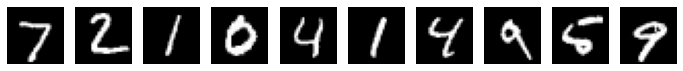

In [14]:
predictions = model.predict(x_t[0:10].reshape((10,28*28)))
print("predictions:",end="")
for predict in predictions:
    print(predict.argmax(axis=0),end="")
print()
print("labels:\t    ",end="")
for label in y_t[0:10]:
    print(label,end="")
plt.figure(figsize=(12,3))
for i in range(10):
    plt.subplot(1,10,(i+1))
    plt.imshow(x_t[i], cmap="gray")
    plt.axis("off")
plt.show()

## Custom Layer

In [16]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, datasets, optimizers, metrics


In [36]:

class Regressor(layers.Layer):
    def __init__(self):
        super(Regressor, self).__init__()
        # [dim_in, dim_out]
        self.w = self.add_variable('abc', [13, 1])
        # [dim_out]
        self.b = self.add_variable('def', [1])
    def call(self, x):
        x = tf.matmul(x, self.w) + self.b
        return x

In [37]:
(x_t, y_t), (x_v, y_v) = datasets.boston_housing.load_data()
def boston_dataset():
    (x_t, y_t), (x_v, y_v) = datasets.boston_housing.load_data()
    print("x_t.shape:", x_t.shape)
    print("x_v.shape", x_v.shape)
    print("y_t.shape", y_t.shape)
    x_t, x_v = x_t.astype(np.float32), x_v.astype(np.float32)
    ds_train = tf.data.Dataset.from_tensor_slices((x_t,y_t)).batch(64)
    ds_val = tf.data.Dataset.from_tensor_slices((x_v,y_v)).batch(102)
    return ds_train, ds_val

ds_train, ds_val = boston_dataset()
layer = Regressor()
criteon = tf.keras.losses.MeanSquaredError()
optimizer = optimizers.Adam(learning_rate=1e-2)


x_t.shape: (404, 13)
x_v.shape (102, 13)
y_t.shape (404,)


In [47]:
ds_train, ds_val = boston_dataset()
def train(dataset):
    for epoch in range(3):
        step_total = 0
        for step, (x,y) in enumerate(dataset):
            step_total += 1
            with tf.GradientTape() as tape:
                logits = layer(x)
                logits =  tf.squeeze(logits, axis=1)
                loss = criteon(y, logits)
            grads = tape.gradient(loss, layer.trainable_variables)
            optimizer.apply_gradients(zip(grads, layer.trainable_variables))
            
            if (step+1) % 2 == 0:
                print((step+1), "loss:{:.4f}".format(loss / step_total))
        print("epoch",epoch, "loss:{:.4f} ".format(loss.numpy() / step_total))
    
train(ds_train)

x_t.shape: (404, 13)
x_v.shape (102, 13)
y_t.shape (404,)
2 loss:218.6010
4 loss:57.1966
6 loss:46.9522
epoch 0 loss:56.0306 
2 loss:192.4347
4 loss:49.7373
6 loss:45.7310
epoch 1 loss:46.5643 
2 loss:167.7911
4 loss:43.6559
6 loss:45.2009
epoch 2 loss:38.8629 


In [48]:
train(ds_val)

epoch 0 loss:253.9355 
epoch 1 loss:251.0693 
epoch 2 loss:248.1583 


In [41]:
layer.weights

[<tf.Variable 'abc:0' shape=(13, 1) dtype=float32, numpy=
 array([[ 0.81119305],
        [ 0.5033438 ],
        [ 0.09181662],
        [-0.25702798],
        [ 0.7896131 ],
        [ 0.44819722],
        [ 0.06434384],
        [ 0.82559675],
        [-0.45509833],
        [ 0.08913743],
        [-0.12547153],
        [-0.1355514 ],
        [ 0.5431093 ]], dtype=float32)>,
 <tf.Variable 'def:0' shape=(1,) dtype=float32, numpy=array([0.84987164], dtype=float32)>]

In [42]:
print(layer.w)
print()
print(layer.b)

<tf.Variable 'abc:0' shape=(13, 1) dtype=float32, numpy=
array([[ 0.81119305],
       [ 0.5033438 ],
       [ 0.09181662],
       [-0.25702798],
       [ 0.7896131 ],
       [ 0.44819722],
       [ 0.06434384],
       [ 0.82559675],
       [-0.45509833],
       [ 0.08913743],
       [-0.12547153],
       [-0.1355514 ],
       [ 0.5431093 ]], dtype=float32)>

<tf.Variable 'def:0' shape=(1,) dtype=float32, numpy=array([0.84987164], dtype=float32)>
